# Gender Prediction Model

In [1]:
import re
import os
import pandas as pd
import numpy as np
import multiprocessing
import ipython_genutils
import pickle
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, MaxPooling1D, LSTM, GRU
from keras.layers import Flatten
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.metrics import classification_report
from sklearn import model_selection
from sklearn import utils
from sklearn.utils import shuffle
from keras.preprocessing.text import Tokenizer
from nltk.tokenize import word_tokenize
import progressbar
import matplotlib.pyplot as plt

Using TensorFlow backend.


### read dataset

In [3]:
df = pd.read_csv('lib/dataset',header=None,encoding = "ISO-8859-1")
df=df.rename(columns={0: 'name'})
tmp=df.name
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5773 entries, 0 to 5772
Data columns (total 1 columns):
name    5773 non-null object
dtypes: object(1)
memory usage: 45.2+ KB


,name
0,Agus Suciono @m
1,Andhien Ristu @f
2,Rani Dwi Astuti @f
3,Rya Afriyati @f
4,Febrian Falentino Fredriktho @m


# Preprocess

data tiap row di split karena nama dan gender masih dalam satu kolom

In [4]:
widgets = [progressbar.Percentage(),progressbar.Bar()," Processed : ",progressbar.Counter(),"  ",progressbar.ETA()]
bar = progressbar.ProgressBar(widgets=widgets, max_value=len(df.index))
bar.start()

name=[]
gender=[]
for index,row in bar(df.iterrows()):
    # split
    tmp=row['name'].split("@")
    name.append(tmp[0])
    gender.append(tmp[1])

100%|########################################| Processed : 5773  Time:  0:00:00


In [5]:
# buat dataframe
df=pd.DataFrame({'name':name,'gender':gender})
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5773 entries, 0 to 5772
Data columns (total 2 columns):
name      5773 non-null object
gender    5773 non-null object
dtypes: object(2)
memory usage: 90.3+ KB


,name,gender
0,Agus Suciono,m
1,Andhien Ristu,f
2,Rani Dwi Astuti,f
3,Rya Afriyati,f
4,Febrian Falentino Fredriktho,m


cek jumlah data tiap kelas

In [6]:
# male   : 0
# female : 1
df['gender']=df['gender'].map({'m':0,'f':1})
df.groupby('gender')['name'].count()

gender
0    1453
1    4320
Name: name, dtype: int64

karena tidak seimbang maka data di downsampling

In [35]:
# shuffle dataset
df = shuffle(df)

# mengambil semua data gender male & female di 2 var berbeda
dfm=df.query('gender == 0')
dff=df.query('gender == 1')

# min jumlah terkecil dari gender male & female
minlen=min(len(dff),len(dfm))

# ambil data male & female sebanyak nilai min
dfm=dfm.head(minlen)
dff=dff.head(minlen)

# gabung
data_training=pd.concat([dff.name,dfm.name])
target=pd.concat([dff.gender,dfm.gender])

nama di split menjadi list huruf, lalu cek nama yg terpanjang untuk nantinya digunakan dalam padding

In [42]:
widgets = [progressbar.Percentage(),progressbar.Bar()," Processed : ",progressbar.Counter(),"  ",progressbar.ETA()]
bar = progressbar.ProgressBar(widgets=widgets, max_value=len(df.index))
bar.start()

maxleng=0
tmp=[]
for index,row in bar(df.iterrows()):
    a=list(row['name'].lower())
    tmp.append(a)
    maxleng=max(maxleng, len(a))
print("max length name : ",maxleng)

100%|#######################################| Processed : 19715  Time:  0:00:06


max length name :  37


 menghapus spasi yg ada di depan nama dan di akhir nama. spasi di antara nama tidak dihapus karena spasi tsb termasuk fitur

In [44]:
widgets = [progressbar.Percentage(),progressbar.Bar()," Processed : ",progressbar.Counter(),"  ",progressbar.ETA()]
bar = progressbar.ProgressBar(widgets=widgets, max_value=len(tmp))
bar.start()

tmp2=[]
for letter in bar(tmp):
    for p in range(maxleng):
        l = len(letter)
        if letter[0]==' ':
            del letter[0]
        elif letter[l-1]==' ':
            del letter[l-1]
    tmp2.append(letter)
data_training=tmp2

100%|#######################################| Processed : 19715  Time:  0:00:00


In [46]:
data_training[0]

['n', 'u', 'r', 'h', 'a', 'y', 'a', 't', 'i']

tokenizing. mengkonversi list huruf menjadi vector angka. menggunakan tokenizer yg sudah dibuat sebelumnya dengan semua dataset. jika blm ada tokenizer maka dibuat terlabih dahulu dengan semua data, tidak di downsampling.

In [ ]:
#save tokenizer
#tokenizer = Tokenizer(num_words=30)
#tokenizer.fit_on_texts(data_training)                        
#sequences = tokenizer.texts_to_sequences(data_training) 
#with open('tokenizer_letter.pickle', 'wb') as handle:
#    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

load tokenizer file lalu konversi

In [202]:
nwords=30
tokenizer = Tokenizer(num_words=nwords)
with open('lib/tokenizer_letter.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)                                
sequences = tokenizer.texts_to_sequences(data_training) 

cek data hasil konevrsi

In [203]:
sequences[0]

[13, 2, 4, 21, 7, 3, 5, 2, 1, 3, 19, 1, 5, 9, 7, 9, 7, 3]

In [204]:
c=0
mlet=0
for x in sequences:
    for y in sequences[c]:
        mlet=max(mlet,y)
print(mlet)

21


padding, menyamakan length vector dengan maxlen = nama terpanjang + 3

In [205]:
input_seq = pad_sequences(sequences, maxlen=maxleng+3)

split dataset menjadi data training dan data validasi

In [206]:
input_train, input_val, target_train, target_val = model_selection.train_test_split(input_seq,target,test_size = 0.2, random_state = 0)
print('data train\t: ',len(input_train))
print('data validasi\t: ',len(input_val),)

data train	:  13771
data validasi	:  3443


cek data yg sudah di preprocess dan ready utk training

In [207]:
input_train[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2, 14,  1, 14,  3,  6,  1,
        4, 23,  1, 15,  1,  3])

# Model

training 4 model
1. CNN
2. LSTM
3. CNN LSTM
4. CNN GRU


semua model menggunakan output fungsi aktivasi sigmoid, dg optimizer adam dan fungsi loss binary crossentropy.

inisiasi embed dimension, epoch dan batch size

In [208]:
embed_dim = 128
epoc=100
batch_size = 32

build model cnn

In [209]:
model = Sequential()
model.add(Embedding(nwords, embed_dim,input_length = input_train.shape[1],trainable=True))
model.add(Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 40, 128)           5120      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 38, 100)           38500     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               25856     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 257       
Total params: 69,733
Trainable params: 69,733
Non-trainable params: 0
_________________________________________________________________


set filepath utk save weights dan set callback untuk mengevaluasi bahwa hanya jika acc naik maka weights akan di save.

In [210]:
filepath="weights_gender_letter_cnn.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history=model.fit(input_train, target_train,validation_data=(input_val, target_val), shuffle=False, epochs=epoc, batch_size=batch_size,callbacks=callbacks_list)

Train on 13771 samples, validate on 3443 samples
Epoch 1/100
13771/13771 [==============================] - 19s 1ms/step - loss: 0.3666 - acc: 0.8399 - val_loss: 0.2882 - val_acc: 0.8760

Epoch 00001: val_acc improved from -inf to 0.87598, saving model to weights_gender_letter_cnn.hdf5
Epoch 2/100
13771/13771 [==============================] - 15s 1ms/step - loss: 0.2625 - acc: 0.8907 - val_loss: 0.2613 - val_acc: 0.8885

Epoch 00002: val_acc improved from 0.87598 to 0.88847, saving model to weights_gender_letter_cnn.hdf5
Epoch 3/100
13771/13771 [==============================] - 15s 1ms/step - loss: 0.2277 - acc: 0.9052 - val_loss: 0.2451 - val_acc: 0.8966

Epoch 00003: val_acc improved from 0.88847 to 0.89660, saving model to weights_gender_letter_cnn.hdf5
Epoch 4/100
13771/13771 [==============================] - 15s 1ms/step - loss: 0.2046 - acc: 0.9178 - val_loss: 0.2428 - val_acc: 0.8957

Epoch 00004: val_acc did not improve from 0.89660
Epoch 5/100
13771/13771 [=================

13771/13771 [==============================] - 15s 1ms/step - loss: 0.0514 - acc: 0.9811 - val_loss: 0.4778 - val_acc: 0.9033

Epoch 00041: val_acc did not improve from 0.90590
Epoch 42/100
13771/13771 [==============================] - 15s 1ms/step - loss: 0.0512 - acc: 0.9814 - val_loss: 0.4445 - val_acc: 0.9036

Epoch 00042: val_acc did not improve from 0.90590
Epoch 43/100
13771/13771 [==============================] - 16s 1ms/step - loss: 0.0467 - acc: 0.9826 - val_loss: 0.4545 - val_acc: 0.8989

Epoch 00043: val_acc did not improve from 0.90590
Epoch 44/100
13771/13771 [==============================] - 15s 1ms/step - loss: 0.0490 - acc: 0.9823 - val_loss: 0.4591 - val_acc: 0.9015

Epoch 00044: val_acc did not improve from 0.90590
Epoch 45/100
13771/13771 [==============================] - 15s 1ms/step - loss: 0.0479 - acc: 0.9824 - val_loss: 0.5083 - val_acc: 0.8969- loss: 0.0491 - acc: 0.9 

Epoch 00045: val_acc did not improve from 0.90590
Epoch 46/100
13771/13771 [===========

score acc

In [211]:
model.load_weights('weights_gender_letter_cnn.hdf5')
scores = model.evaluate(input_val, target_val)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

3443/3443 [==============================] - 1s 329us/step

acc: 90.94%


In [212]:
from sklearn.metrics import classification_report
predict = model.predict_classes(input_val)
y_true = target_val
y_pred = predict
target_names = ['male', 'female',]
print (classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      female       0.90      0.92      0.91      1738
        male       0.92      0.90      0.91      1705

   micro avg       0.91      0.91      0.91      3443
   macro avg       0.91      0.91      0.91      3443
weighted avg       0.91      0.91      0.91      3443



plot acc dan loss

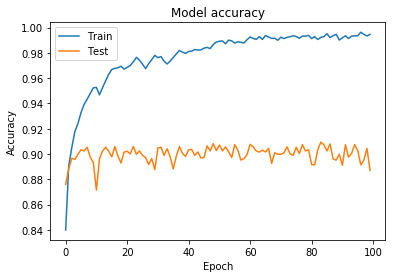

In [213]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

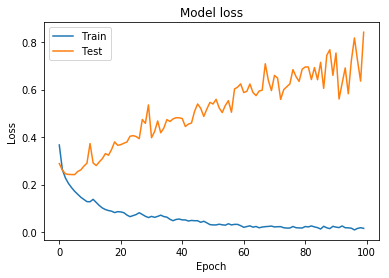

In [214]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

build model lstm

In [240]:
model = Sequential()
model.add(Embedding(nwords, embed_dim,input_length = input_train.shape[1],trainable=True))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 40, 128)           5120      
_________________________________________________________________
dropout_24 (Dropout)         (None, 40, 128)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 40, 100)           91600     
_________________________________________________________________
dropout_25 (Dropout)         (None, 40, 100)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_26 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 101       
Total para

set filepath utk save weights dan set callback untuk mengevaluasi bahwa hanya jika acc naik maka weights akan di save.

In [242]:
filepath="weights_gender_letter_lstm.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history=model.fit(input_train, target_train,validation_data=(input_val, target_val), shuffle=False, epochs=epoc, batch_size=batch_size,callbacks=callbacks_list)

Train on 13771 samples, validate on 3443 samples
Epoch 1/100
13771/13771 [==============================] - 104s 8ms/step - loss: 0.5242 - acc: 0.7419 - val_loss: 0.4471 - val_acc: 0.7886

Epoch 00001: val_acc improved from -inf to 0.78856, saving model to weights_gender_letter_lstm.hdf5
Epoch 2/100
13771/13771 [==============================] - 90s 7ms/step - loss: 0.3890 - acc: 0.8230 - val_loss: 0.3281 - val_acc: 0.8617

Epoch 00002: val_acc improved from 0.78856 to 0.86175, saving model to weights_gender_letter_lstm.hdf5
Epoch 3/100
13771/13771 [==============================] - 89s 6ms/step - loss: 0.3166 - acc: 0.8673 - val_loss: 0.2887 - val_acc: 0.8821

Epoch 00003: val_acc improved from 0.86175 to 0.88208, saving model to weights_gender_letter_lstm.hdf5
Epoch 4/100
13771/13771 [==============================] - 89s 6ms/step - loss: 0.2841 - acc: 0.8836 - val_loss: 0.2660 - val_acc: 0.8902

Epoch 00004: val_acc improved from 0.88208 to 0.89021, saving model to weights_gender_le

13771/13771 [==============================] - 85s 6ms/step - loss: 0.0106 - acc: 0.9962 - val_loss: 0.4904 - val_acc: 0.9219

Epoch 00081: val_acc did not improve from 0.92855
Epoch 82/100
13771/13771 [==============================] - 76s 6ms/step - loss: 0.0089 - acc: 0.9974 - val_loss: 0.4580 - val_acc: 0.9265

Epoch 00082: val_acc did not improve from 0.92855
Epoch 83/100
13771/13771 [==============================] - 77s 6ms/step - loss: 0.0086 - acc: 0.9969 - val_loss: 0.4798 - val_acc: 0.9242

Epoch 00083: val_acc did not improve from 0.92855
Epoch 84/100
13771/13771 [==============================] - 77s 6ms/step - loss: 0.0113 - acc: 0.9961 - val_loss: 0.4527 - val_acc: 0.9213

Epoch 00084: val_acc did not improve from 0.92855
Epoch 85/100
13771/13771 [==============================] - 79s 6ms/step - loss: 0.0148 - acc: 0.9948 - val_loss: 0.4757 - val_acc: 0.9259

Epoch 00085: val_acc did not improve from 0.92855
Epoch 86/100
13771/13771 [==============================] - 78s

score acc

In [243]:
model.load_weights("weights_gender_letter_lstm.hdf5")
scores = model.evaluate(input_val, target_val)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

3443/3443 [==============================] - 5s 1ms/step

acc: 92.86%


In [244]:
from sklearn.metrics import classification_report
predict = model.predict_classes(input_val)
y_true = target_val
y_pred = predict
target_names = ['male', 'female',]
print (classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        male       0.94      0.92      0.93      1738
      female       0.92      0.94      0.93      1705

   micro avg       0.93      0.93      0.93      3443
   macro avg       0.93      0.93      0.93      3443
weighted avg       0.93      0.93      0.93      3443



plot acc dan loss

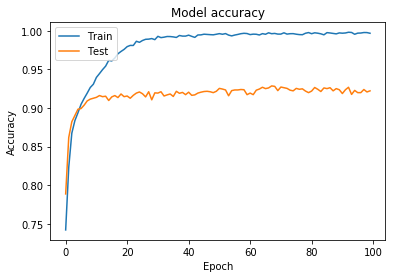

In [245]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

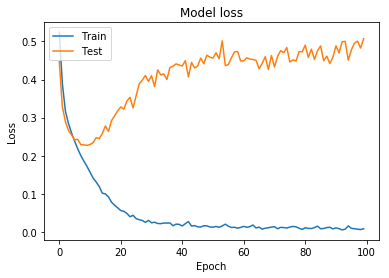

In [246]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

build model cnn lstm

In [247]:
model = Sequential()
model.add(Embedding(nwords, embed_dim,input_length = input_train.shape[1],trainable=True))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100,return_sequences=False))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 40, 128)           5120      
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 40, 32)            12320     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 20, 32)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 20, 32)            3104      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 10, 32)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 10, 100)           53200     
_________________________________________________________________
dropout_27 (Dropout)         (None, 10, 100)           0         
__________

set filepath utk save weights dan set callback untuk mengevaluasi bahwa hanya jika acc naik maka weights akan di save.

In [248]:
filepath="weights_gender_letter_cnn-lstm.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history=model.fit(input_train, target_train,validation_data=(input_val, target_val), shuffle=False, epochs=epoc, batch_size=batch_size,callbacks=callbacks_list)

Train on 13771 samples, validate on 3443 samples
Epoch 1/100
13771/13771 [==============================] - 41s 3ms/step - loss: 0.4102 - acc: 0.8077 - val_loss: 0.3041 - val_acc: 0.8693

Epoch 00001: val_acc improved from -inf to 0.86930, saving model to weights_gender_letter_cnn-lstm.hdf5
Epoch 2/100
13771/13771 [==============================] - 30s 2ms/step - loss: 0.2817 - acc: 0.8841 - val_loss: 0.2654 - val_acc: 0.8908

Epoch 00002: val_acc improved from 0.86930 to 0.89079, saving model to weights_gender_letter_cnn-lstm.hdf5
Epoch 3/100
13771/13771 [==============================] - 30s 2ms/step - loss: 0.2412 - acc: 0.9039 - val_loss: 0.2539 - val_acc: 0.8981

Epoch 00003: val_acc improved from 0.89079 to 0.89805, saving model to weights_gender_letter_cnn-lstm.hdf5
Epoch 4/100
13771/13771 [==============================] - 30s 2ms/step - loss: 0.2206 - acc: 0.9121 - val_loss: 0.2484 - val_acc: 0.8969

Epoch 00004: val_acc did not improve from 0.89805
Epoch 5/100
13771/13771 [==

13771/13771 [==============================] - 30s 2ms/step - loss: 0.0142 - acc: 0.9940 - val_loss: 0.5536 - val_acc: 0.9030

Epoch 00083: val_acc did not improve from 0.91635
Epoch 84/100
13771/13771 [==============================] - 30s 2ms/step - loss: 0.0152 - acc: 0.9944 - val_loss: 0.5758 - val_acc: 0.9039

Epoch 00084: val_acc did not improve from 0.91635
Epoch 85/100
13771/13771 [==============================] - 31s 2ms/step - loss: 0.0163 - acc: 0.9949 - val_loss: 0.5507 - val_acc: 0.9053

Epoch 00085: val_acc did not improve from 0.91635
Epoch 86/100
13771/13771 [==============================] - 31s 2ms/step - loss: 0.0092 - acc: 0.9970 - val_loss: 0.5781 - val_acc: 0.9079

Epoch 00086: val_acc did not improve from 0.91635
Epoch 87/100
13771/13771 [==============================] - 31s 2ms/step - loss: 0.0200 - acc: 0.9926 - val_loss: 0.5011 - val_acc: 0.9091

Epoch 00087: val_acc did not improve from 0.91635
Epoch 88/100
13771/13771 [==============================] - 31s

score acc

In [249]:
model.load_weights("weights_gender_letter_cnn-lstm.hdf5")
scores = model.evaluate(input_val, target_val)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

3443/3443 [==============================] - 2s 554us/step

acc: 91.64%


In [250]:
from sklearn.metrics import classification_report
predict = model.predict_classes(input_val)
y_true = target_val
y_pred = predict
target_names = ['male', 'female',]
print (classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        male       0.91      0.92      0.92      1738
      female       0.92      0.91      0.91      1705

   micro avg       0.92      0.92      0.92      3443
   macro avg       0.92      0.92      0.92      3443
weighted avg       0.92      0.92      0.92      3443



plot acc dan los

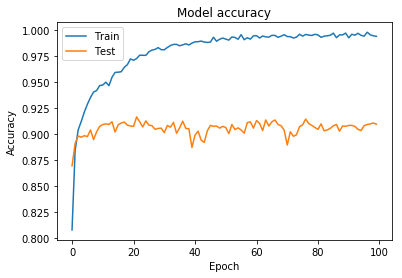

In [251]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

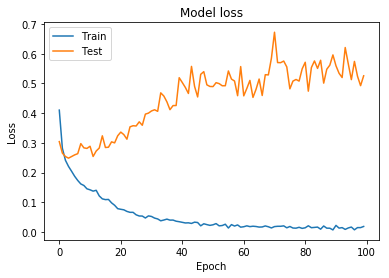

In [252]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

build model cnn gru

In [229]:
model = Sequential()
model.add(Embedding(nwords, embed_dim,input_length = input_train.shape[1],trainable=True))
model.add(Conv1D(32,kernel_size=3,padding='same',activation='relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.3))
model.add(Conv1D(64,kernel_size=3,padding='same',activation='relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.35))
model.add(Conv1D(128,kernel_size=3,padding='same',activation='relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.4))
model.add(GRU(50,return_sequences=True))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.45))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 40, 128)           5120      
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 40, 32)            12320     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 20, 32)            0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 20, 32)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 20, 64)            6208      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 10, 64)            0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 10, 64)            0         
__________

save model

In [ ]:
model_json = model.to_json()
with open("model_gender_letter.json", "w") as json_file:
    json_file.write(model_json)

set filepath utk save weights dan set callback untuk mengevaluasi bahwa hanya jika acc naik maka weights akan di save.

In [230]:
filepath="weights_gender_letter_cnn-lstm2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history=model.fit(input_train, target_train,validation_data=(input_val, target_val), shuffle=False, epochs=epoc, batch_size=batch_size,callbacks=callbacks_list)

Train on 13771 samples, validate on 3443 samples
Epoch 1/100
13771/13771 [==============================] - 30s 2ms/step - loss: 0.4840 - acc: 0.7575 - val_loss: 0.3534 - val_acc: 0.8495

Epoch 00001: val_acc improved from -inf to 0.84955, saving model to wweights_gender_letter_cnn-lstm2.hdf5
Epoch 2/100
13771/13771 [==============================] - 21s 2ms/step - loss: 0.3386 - acc: 0.8593 - val_loss: 0.2894 - val_acc: 0.8766

Epoch 00002: val_acc improved from 0.84955 to 0.87656, saving model to wweights_gender_letter_cnn-lstm2.hdf5
Epoch 3/100
13771/13771 [==============================] - 20s 1ms/step - loss: 0.3091 - acc: 0.8706 - val_loss: 0.2896 - val_acc: 0.8795

Epoch 00003: val_acc improved from 0.87656 to 0.87947, saving model to wweights_gender_letter_cnn-lstm2.hdf5
Epoch 4/100
13771/13771 [==============================] - 20s 1ms/step - loss: 0.2920 - acc: 0.8805 - val_loss: 0.2628 - val_acc: 0.8928

Epoch 00004: val_acc improved from 0.87947 to 0.89283, saving model to 

13771/13771 [==============================] - 18s 1ms/step - loss: 0.1704 - acc: 0.9336 - val_loss: 0.1883 - val_acc: 0.9254

Epoch 00080: val_acc did not improve from 0.93204
Epoch 81/100
13771/13771 [==============================] - 21s 2ms/step - loss: 0.1679 - acc: 0.9326 - val_loss: 0.1891 - val_acc: 0.9268

Epoch 00081: val_acc did not improve from 0.93204
Epoch 82/100
13771/13771 [==============================] - 20s 1ms/step - loss: 0.1713 - acc: 0.9341 - val_loss: 0.2014 - val_acc: 0.9233

Epoch 00082: val_acc did not improve from 0.93204
Epoch 83/100
13771/13771 [==============================] - 20s 1ms/step - loss: 0.1717 - acc: 0.9338 - val_loss: 0.1954 - val_acc: 0.9280

Epoch 00083: val_acc did not improve from 0.93204
Epoch 84/100
13771/13771 [==============================] - 20s 1ms/step - loss: 0.1693 - acc: 0.9341 - val_loss: 0.1973 - val_acc: 0.9259 0s - loss: 0.1702 - acc

Epoch 00084: val_acc did not improve from 0.93204
Epoch 85/100
13771/13771 [=============

score acc

In [231]:
model.load_weights("weights_gender_letter_cnn-lstm2.hdf5")
scores = model.evaluate(input_val, target_val)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

3443/3443 [==============================] - 1s 436us/step

acc: 93.20%


In [232]:
from sklearn.metrics import classification_report
predict = model.predict_classes(input_val)
y_true = target_val
y_pred = predict
target_names = ['male', 'female',]
print (classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        male       0.94      0.93      0.93      1738
      female       0.93      0.93      0.93      1705

   micro avg       0.93      0.93      0.93      3443
   macro avg       0.93      0.93      0.93      3443
weighted avg       0.93      0.93      0.93      3443



plot acc dan loss

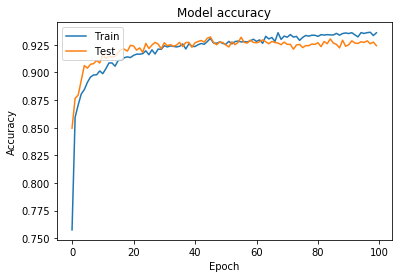

In [233]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

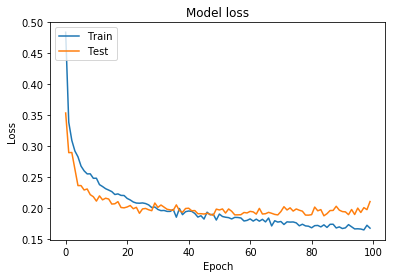

In [234]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Predict

In [268]:
nama="Choiril Kurniawan"

In [269]:
nama=nama.lower()
nama= list(nama)
tmp=[]
tmp.append(nama)
tmp.append(nama)
sequences = tokenizer.texts_to_sequences(tmp) 
input_seq = pad_sequences(sequences, maxlen=maxleng+3)

In [270]:
# male   : 0
# female : 1
result=model.predict_classes(input_seq)
print(result[0])

[0]
